In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pandas.plotting import scatter_matrix
import pickle

In [4]:
water_quality_df_1 = pd.read_csv("./data/water-quality-site1.csv")
water_quality_df_2 = pd.read_csv("./data/water-quality-site2.csv")
water_quality_df_3 = pd.read_csv("./data/water-quality-site3.csv")
water_quality_df_4 = pd.read_csv("./data/water-quality-site4.csv")

# Lat, Long ,Time, Date 
water_quality_columns_to_drop = ['Latitude', 'Longitude', 'Time', 'Date', 'Nitrite (mg/L)']

In [5]:
### CLEAN DATA BY FILLING EMPTY COLUMS WITH MEAN VALUE

def fill_in_empty_cells_with_average(df):
    df = df.drop(columns=water_quality_columns_to_drop)
    for col in df:    
        df[col].fillna(value=df[col].mean(), inplace=True)
    return df

water_quality_df_1 = fill_in_empty_cells_with_average(water_quality_df_1)
water_quality_df_2 = fill_in_empty_cells_with_average(water_quality_df_2)
water_quality_df_3 = fill_in_empty_cells_with_average(water_quality_df_3)
water_quality_df_4 = fill_in_empty_cells_with_average(water_quality_df_4)

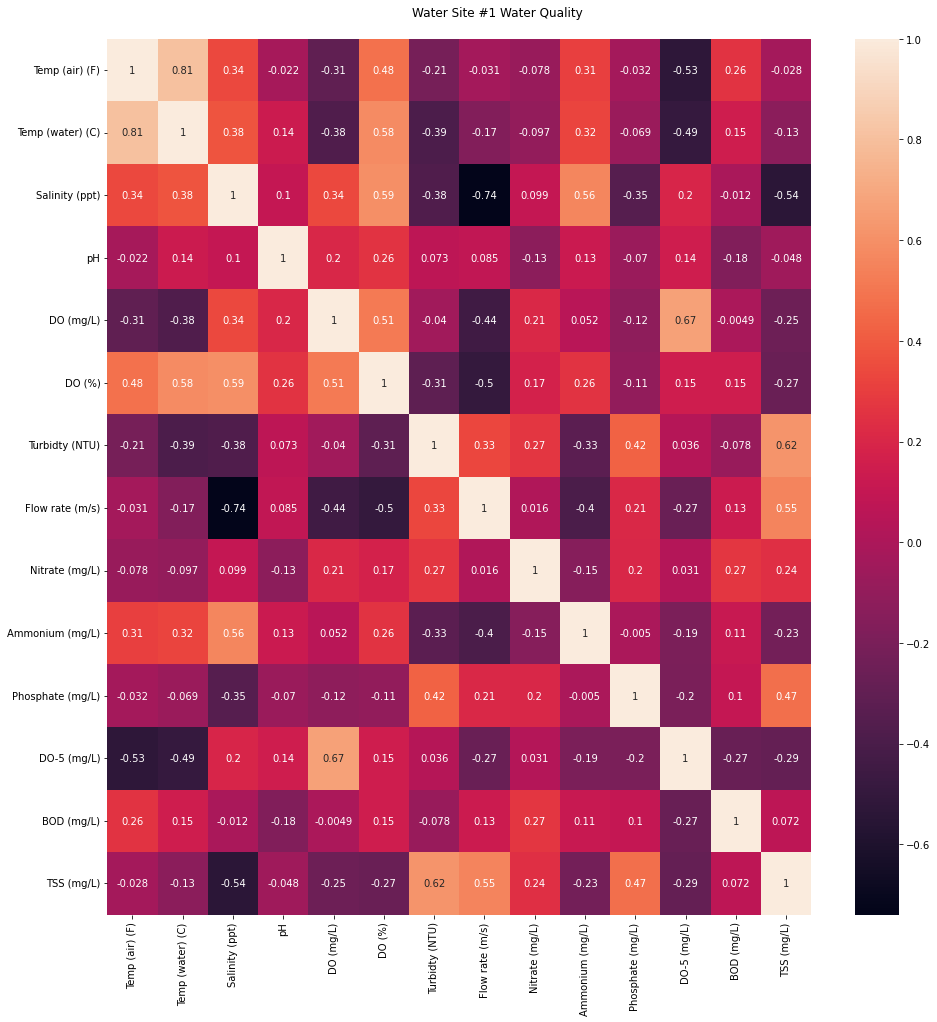

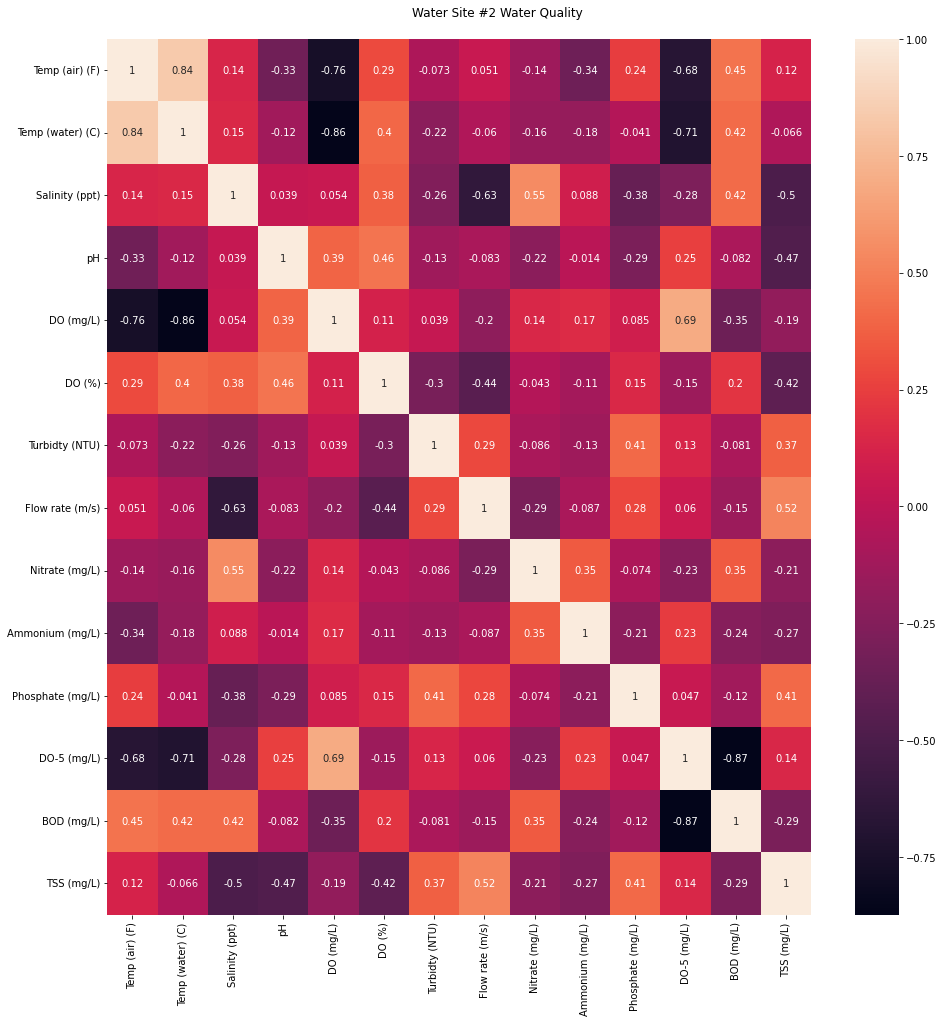

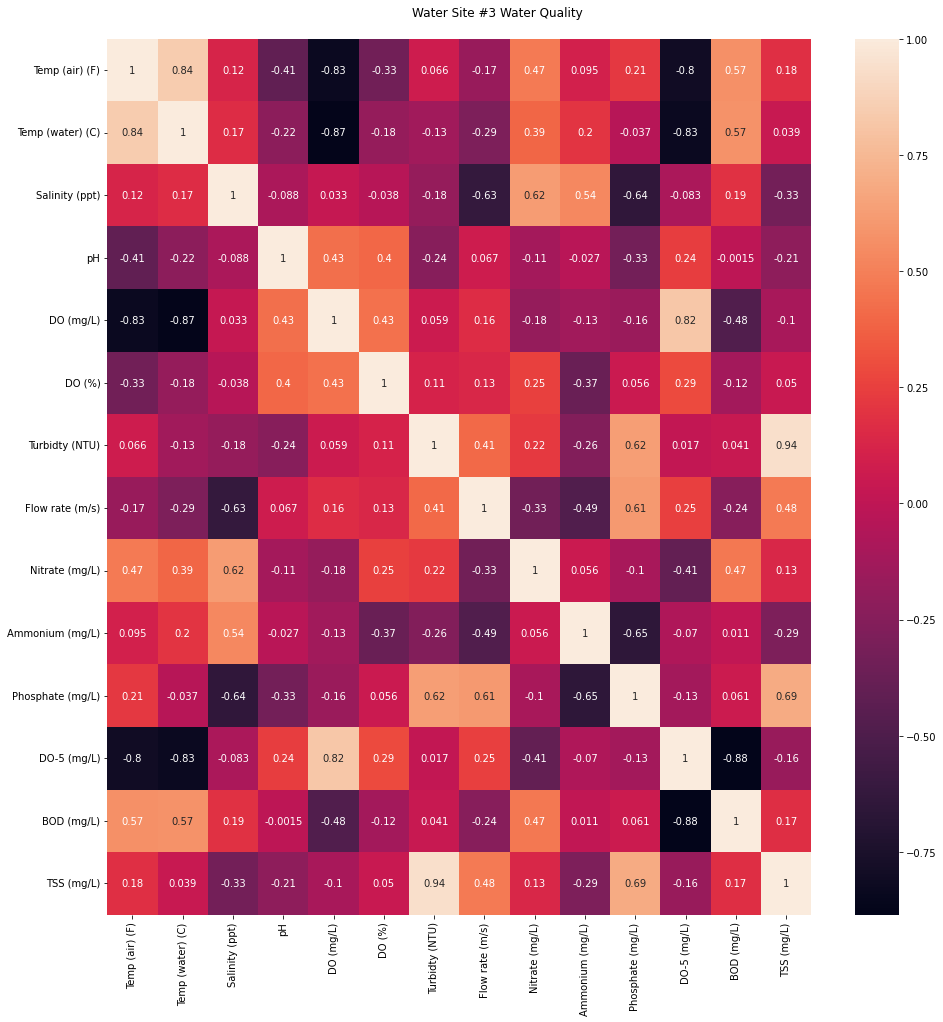

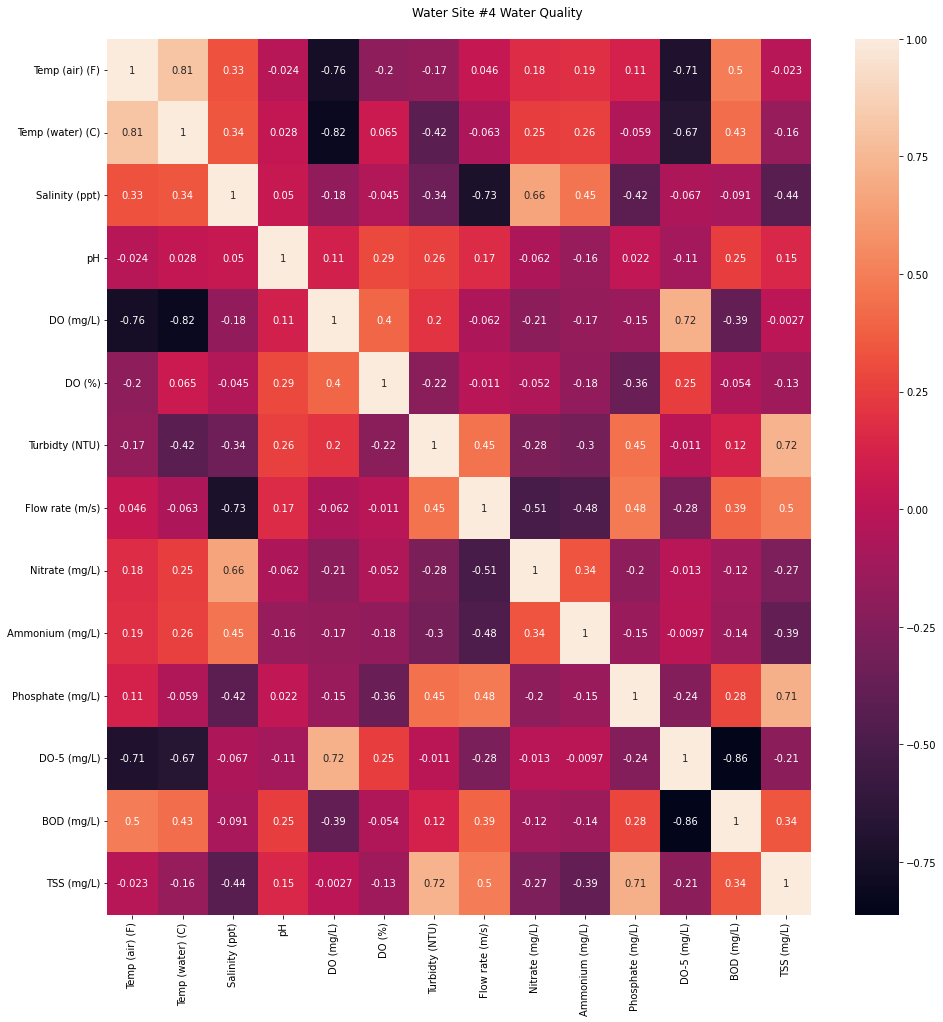

In [8]:
def make_correlation_matrix(dataframe, name, filename):
    corr_matrix = dataframe.corr()
    plt.subplots(figsize=(15,15))
    figure = sn.heatmap(corr_matrix, annot=True).get_figure()
    figure.tight_layout(pad=5.0)
    figure.suptitle(name)
    figure.subplots_adjust(top=0.95)
    figure.savefig(filename)
    corr_matrix = dataframe.corr()

make_correlation_matrix(water_quality_df_1, "Water Site #1 Water Quality",'water-site-1-cm.png')
make_correlation_matrix(water_quality_df_2, "Water Site #2 Water Quality",'water-site-2-cm.png')
make_correlation_matrix(water_quality_df_3, "Water Site #3 Water Quality",'water-site-3-cm.png')
make_correlation_matrix(water_quality_df_4, "Water Site #4 Water Quality",'water-site-4-cm.png')

pickle.dump(water_quality_df_1, open("water_quality_df_1.pkl",'wb'))
pickle.dump(water_quality_df_2, open("water_quality_df_2.pkl",'wb'))
pickle.dump(water_quality_df_3, open("water_quality_df_3.pkl",'wb'))
pickle.dump(water_quality_df_4, open("water_quality_df_4.pkl",'wb'))

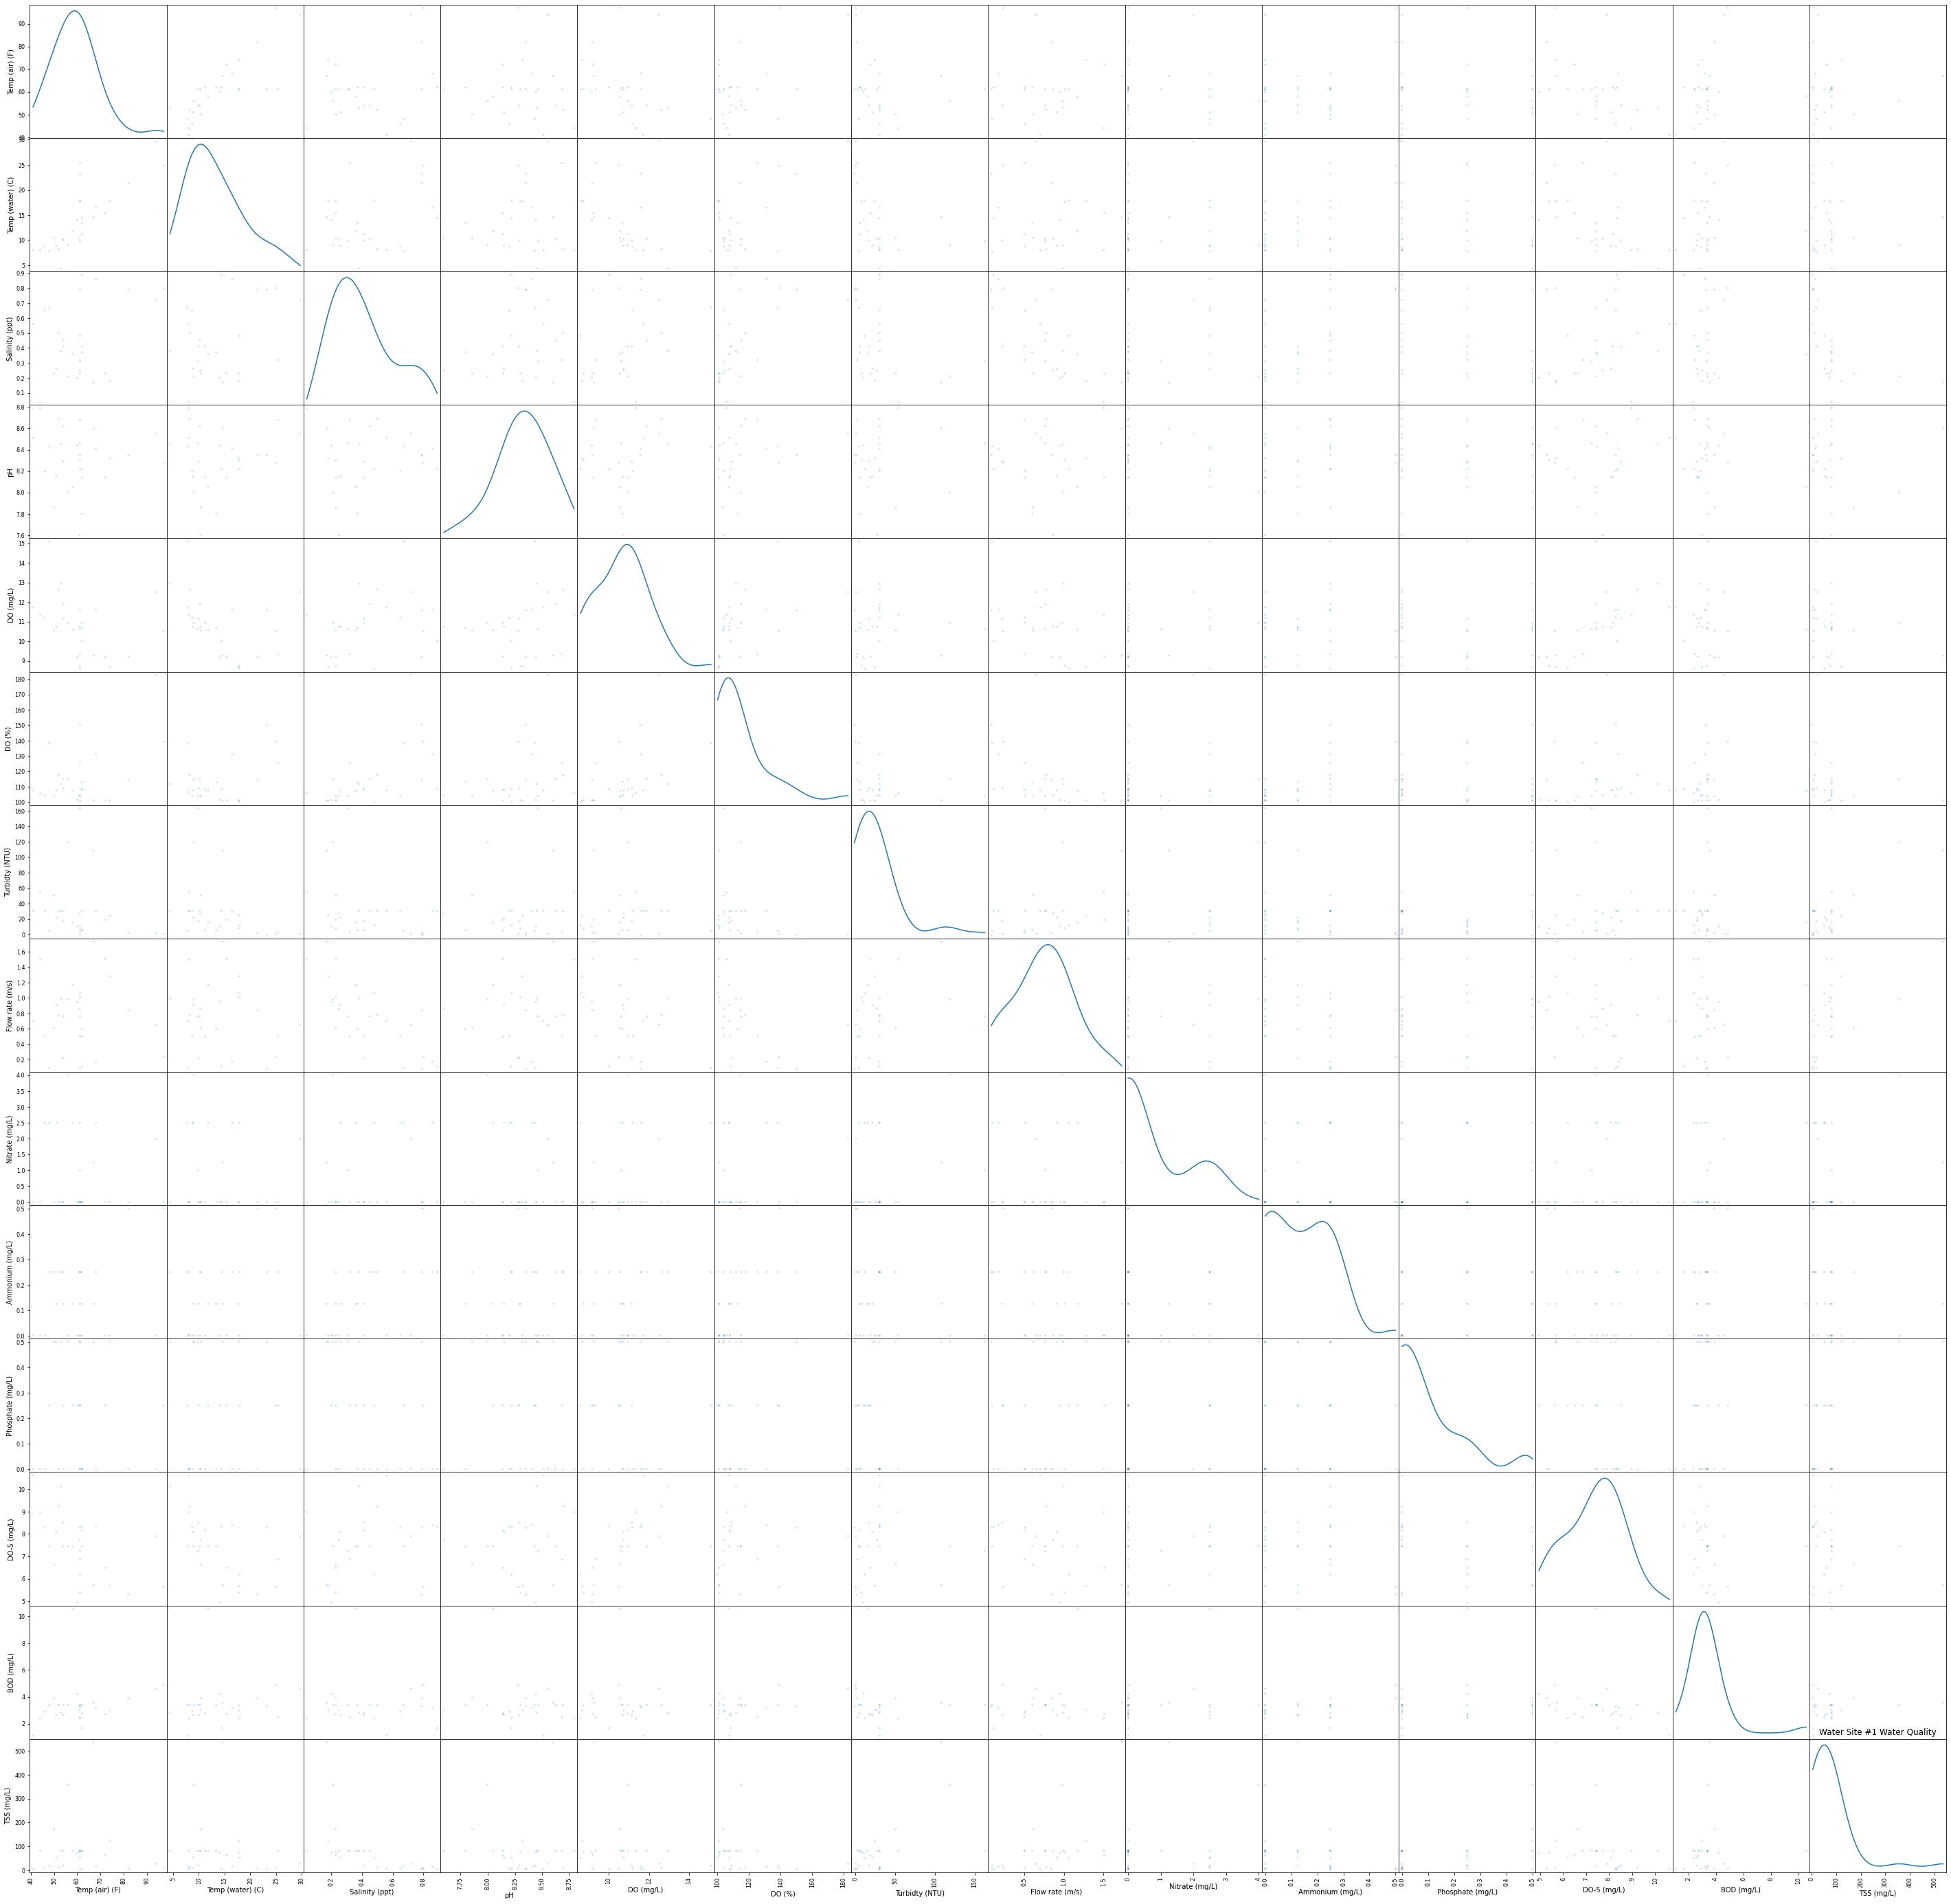

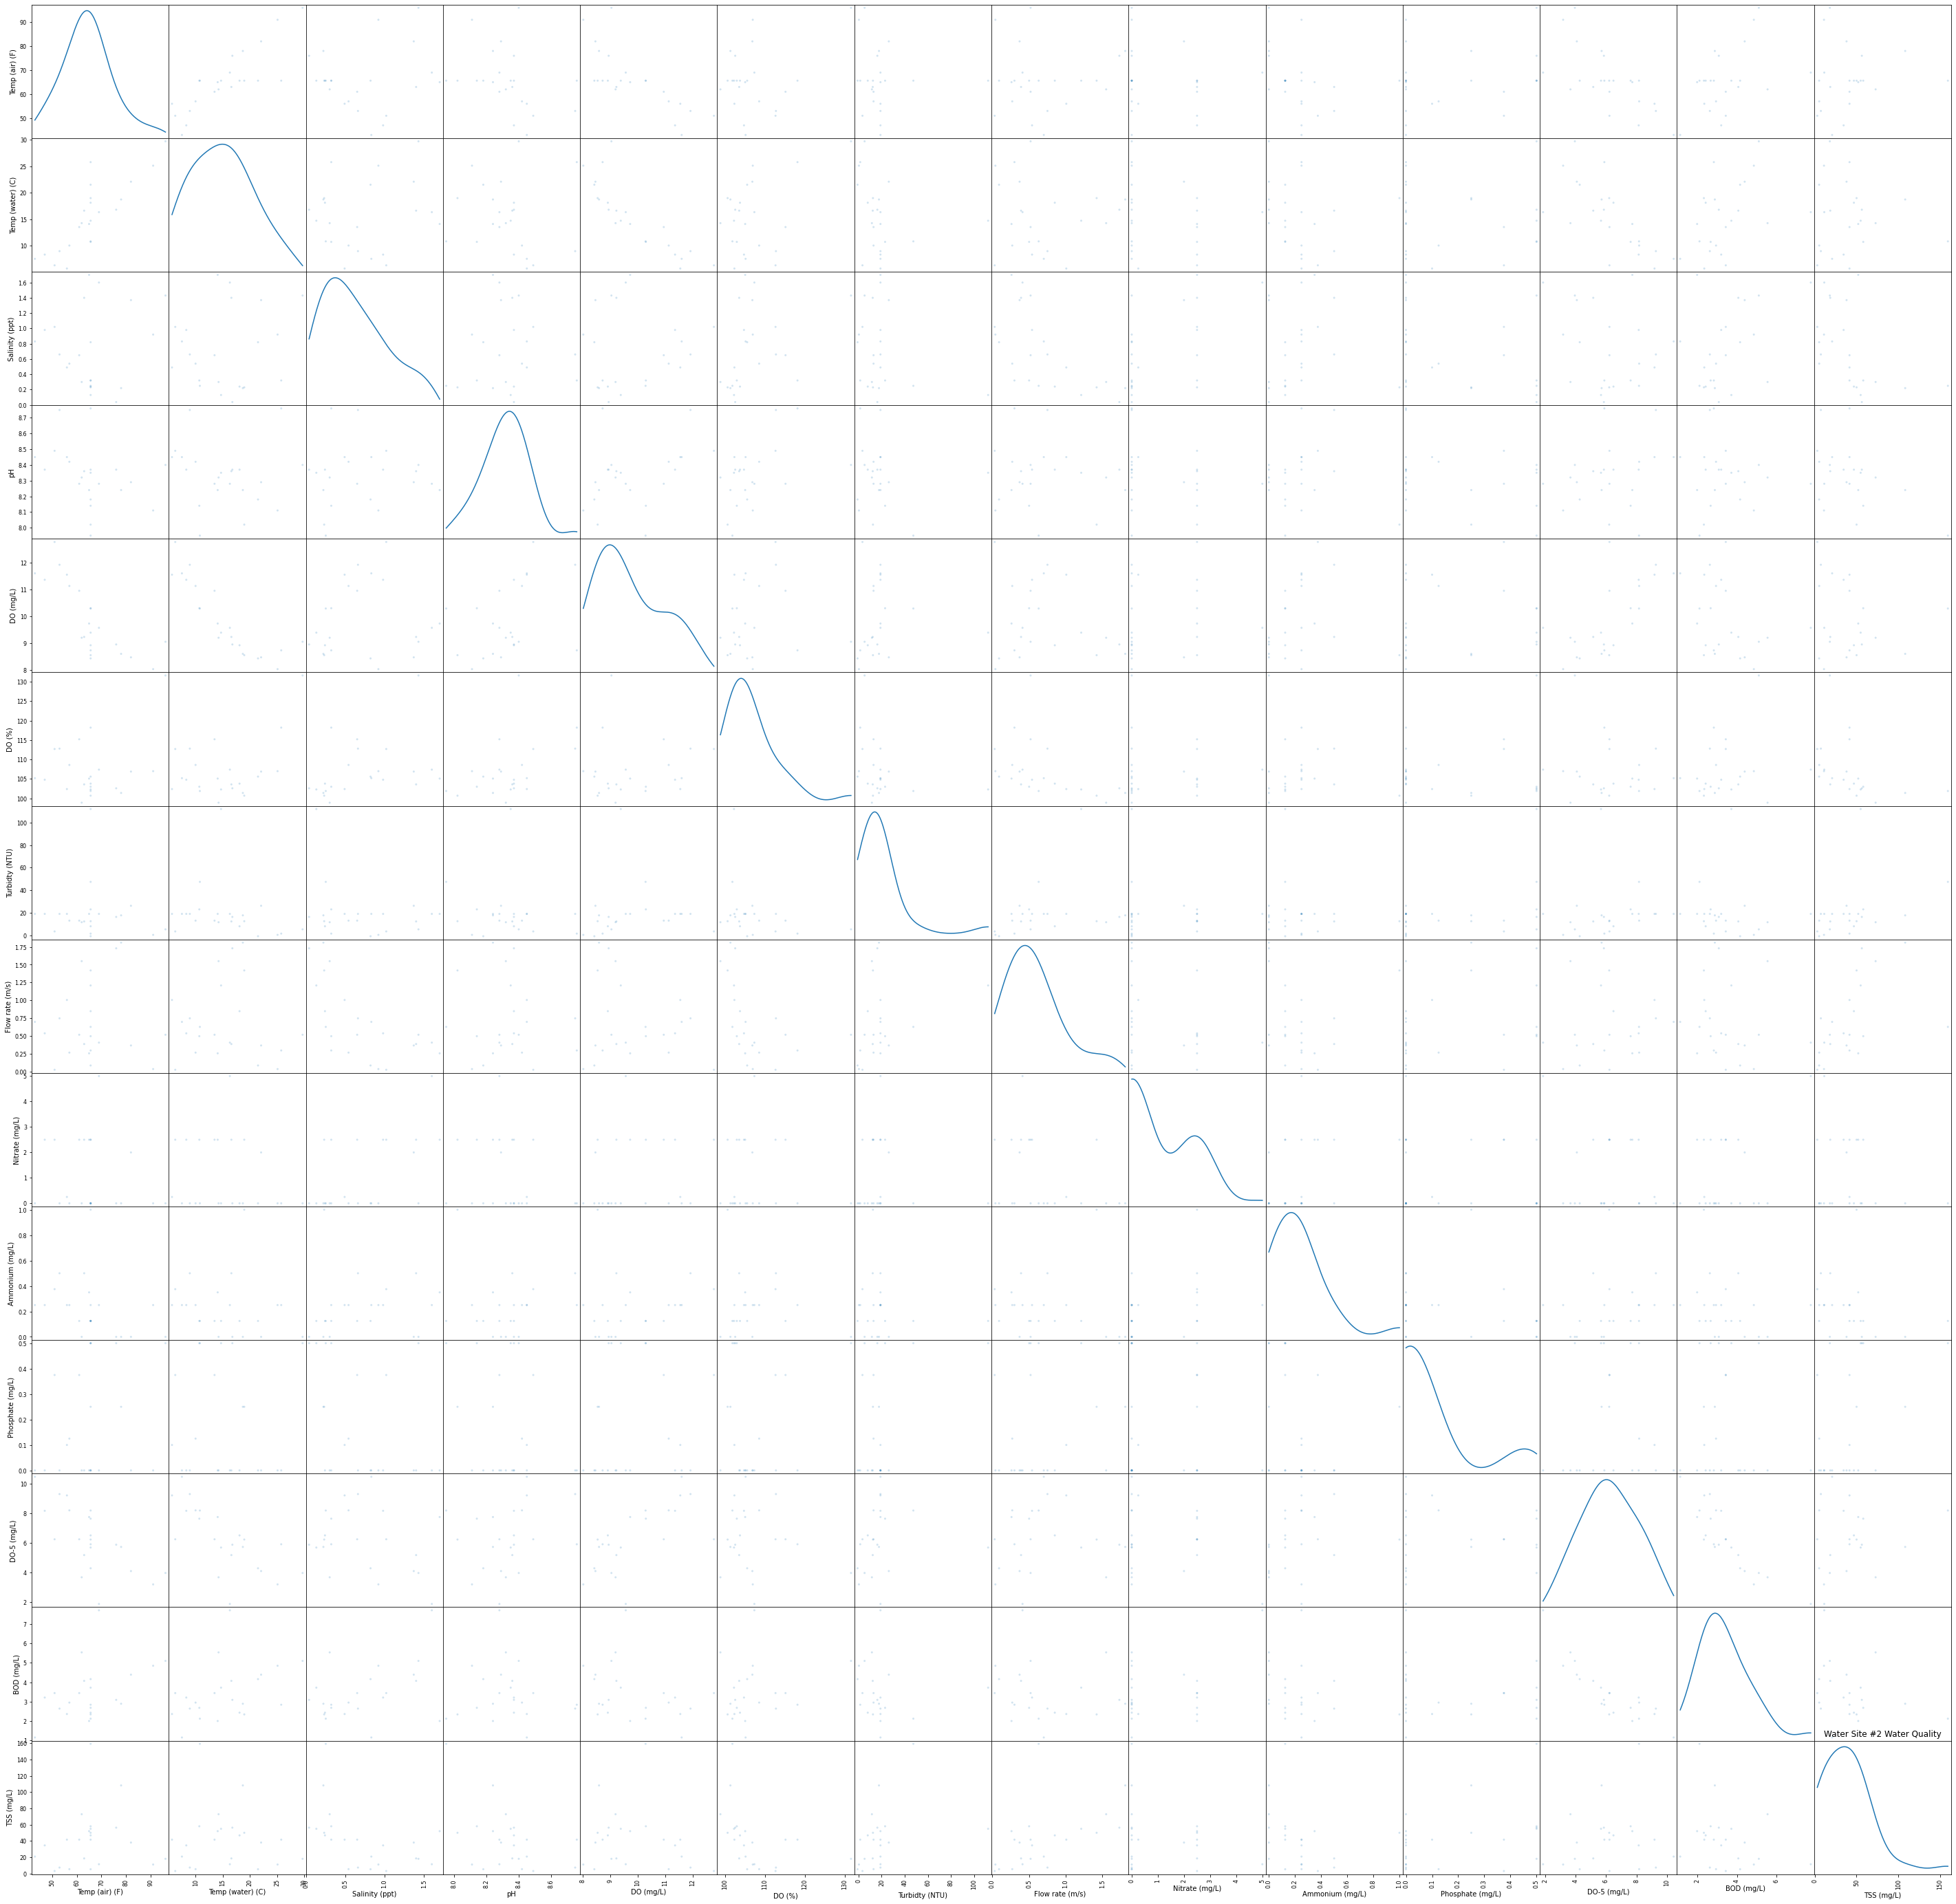

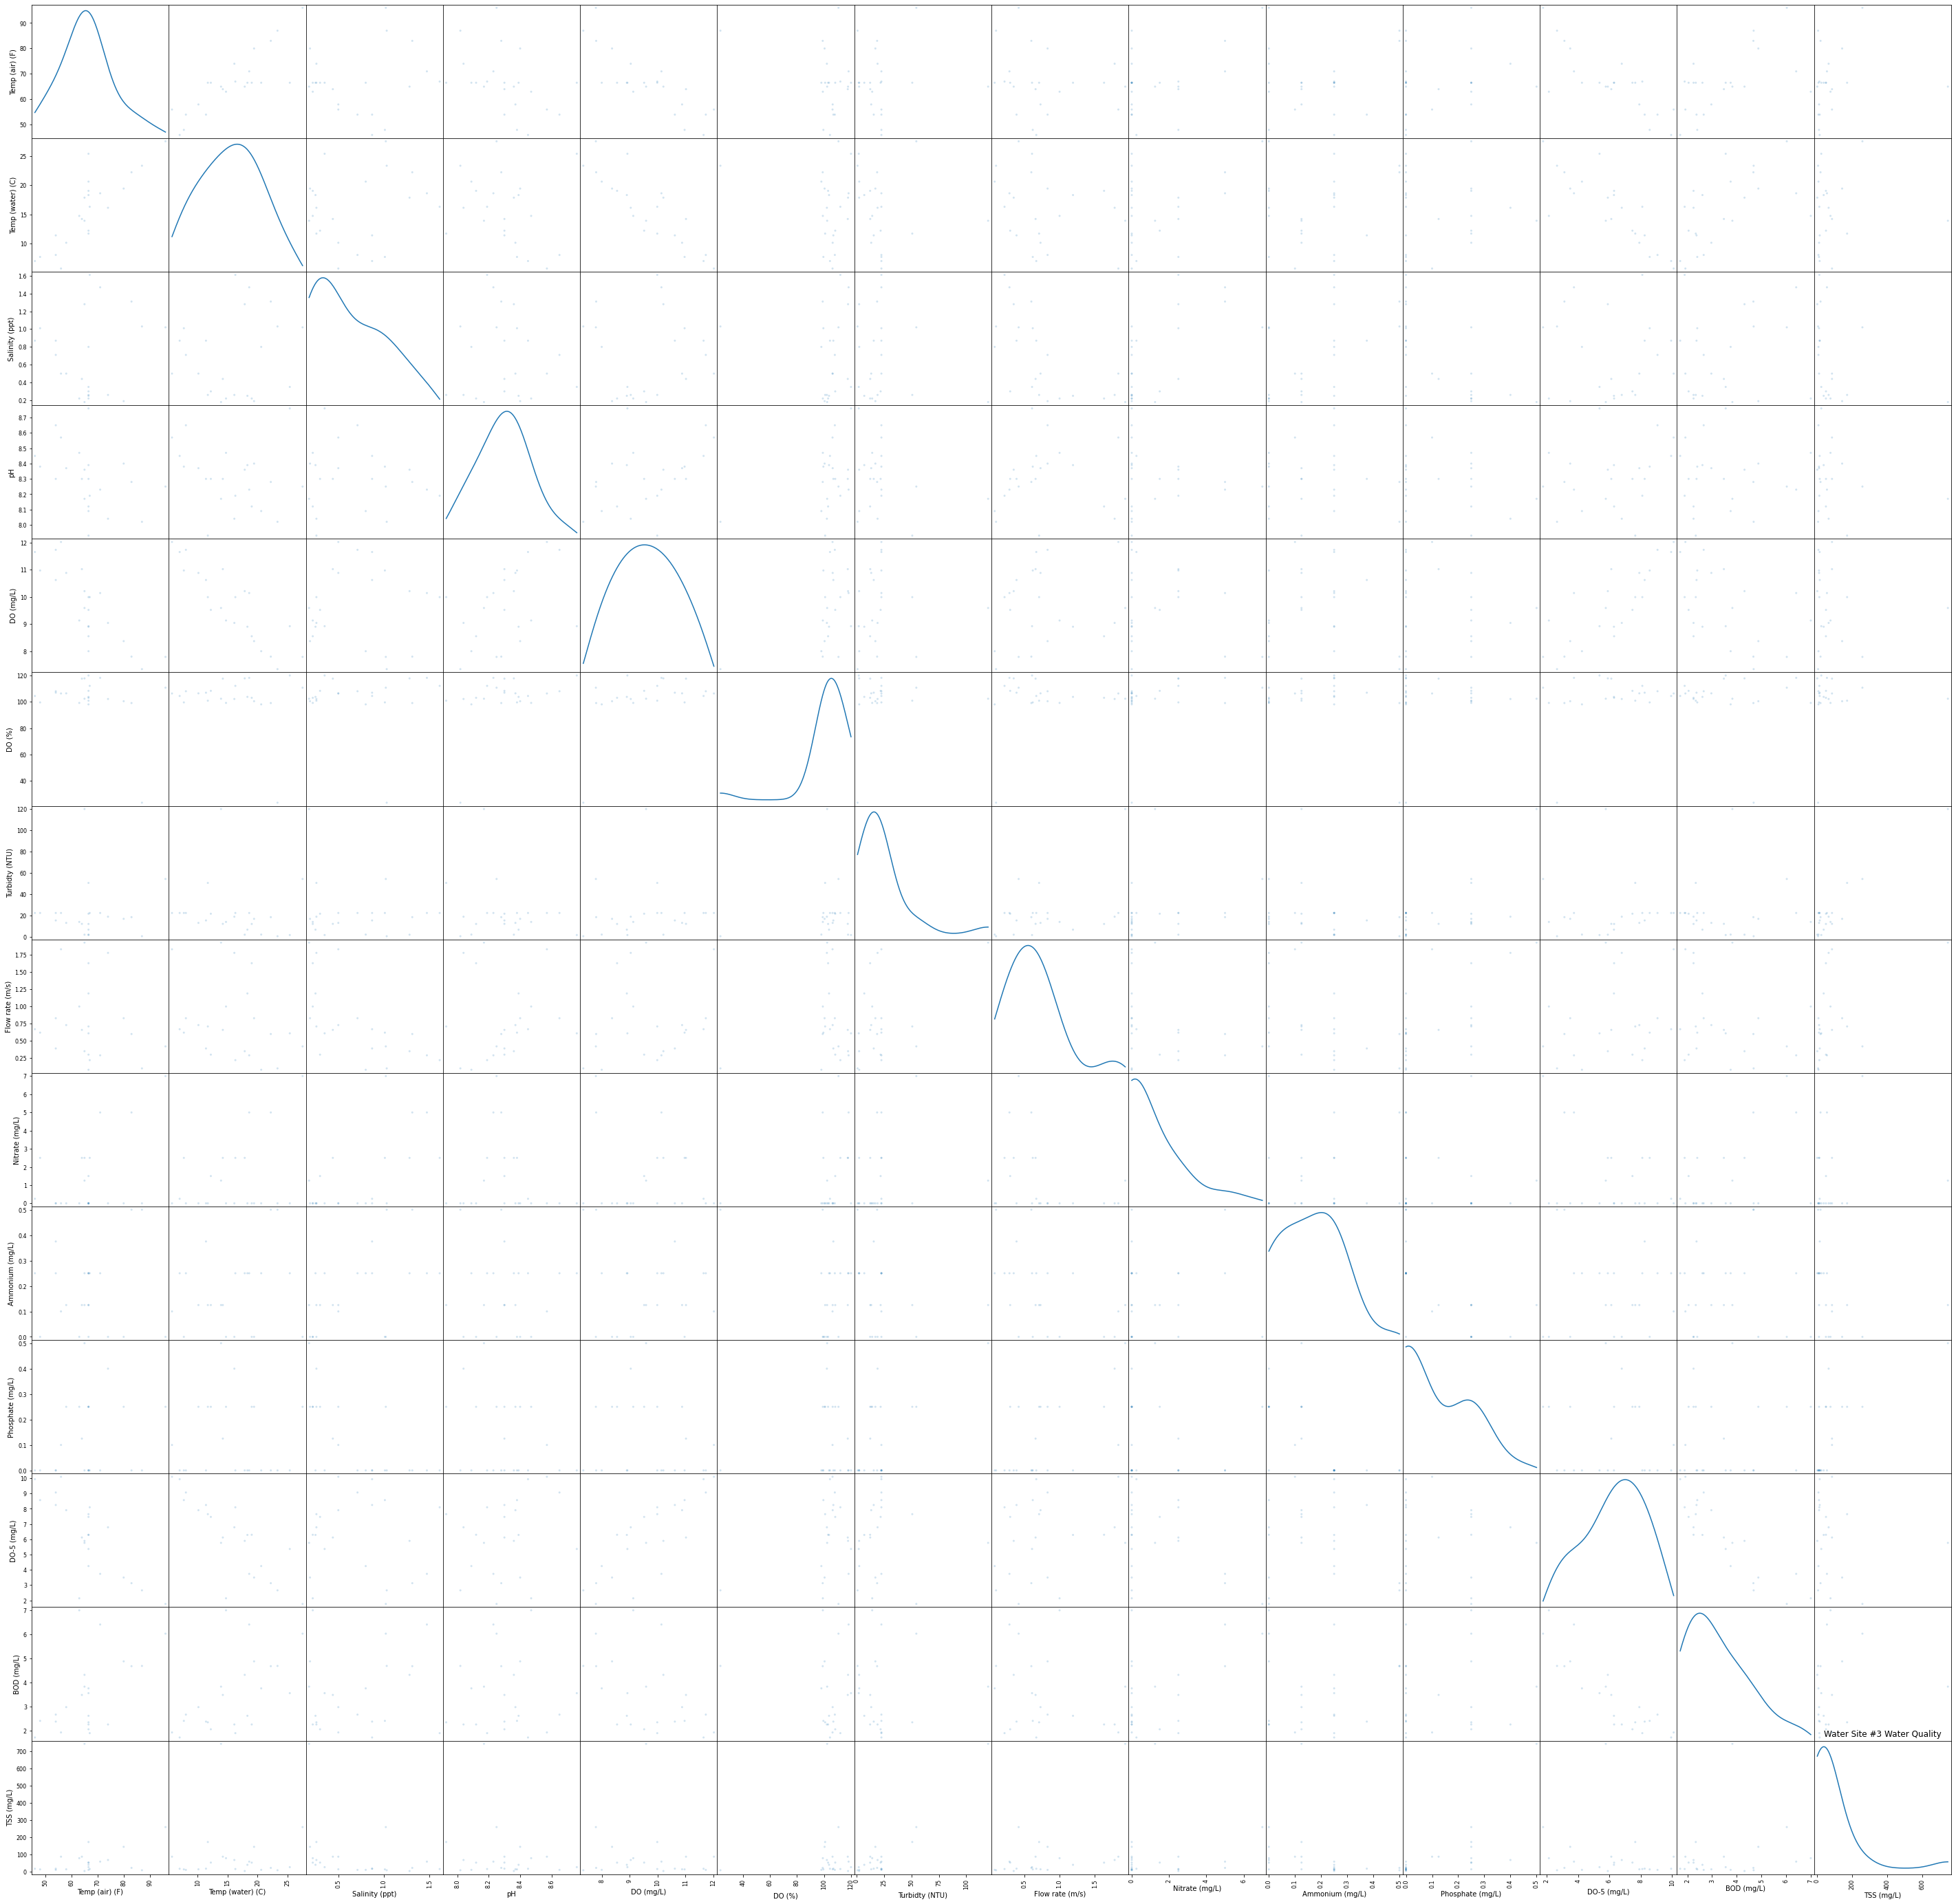

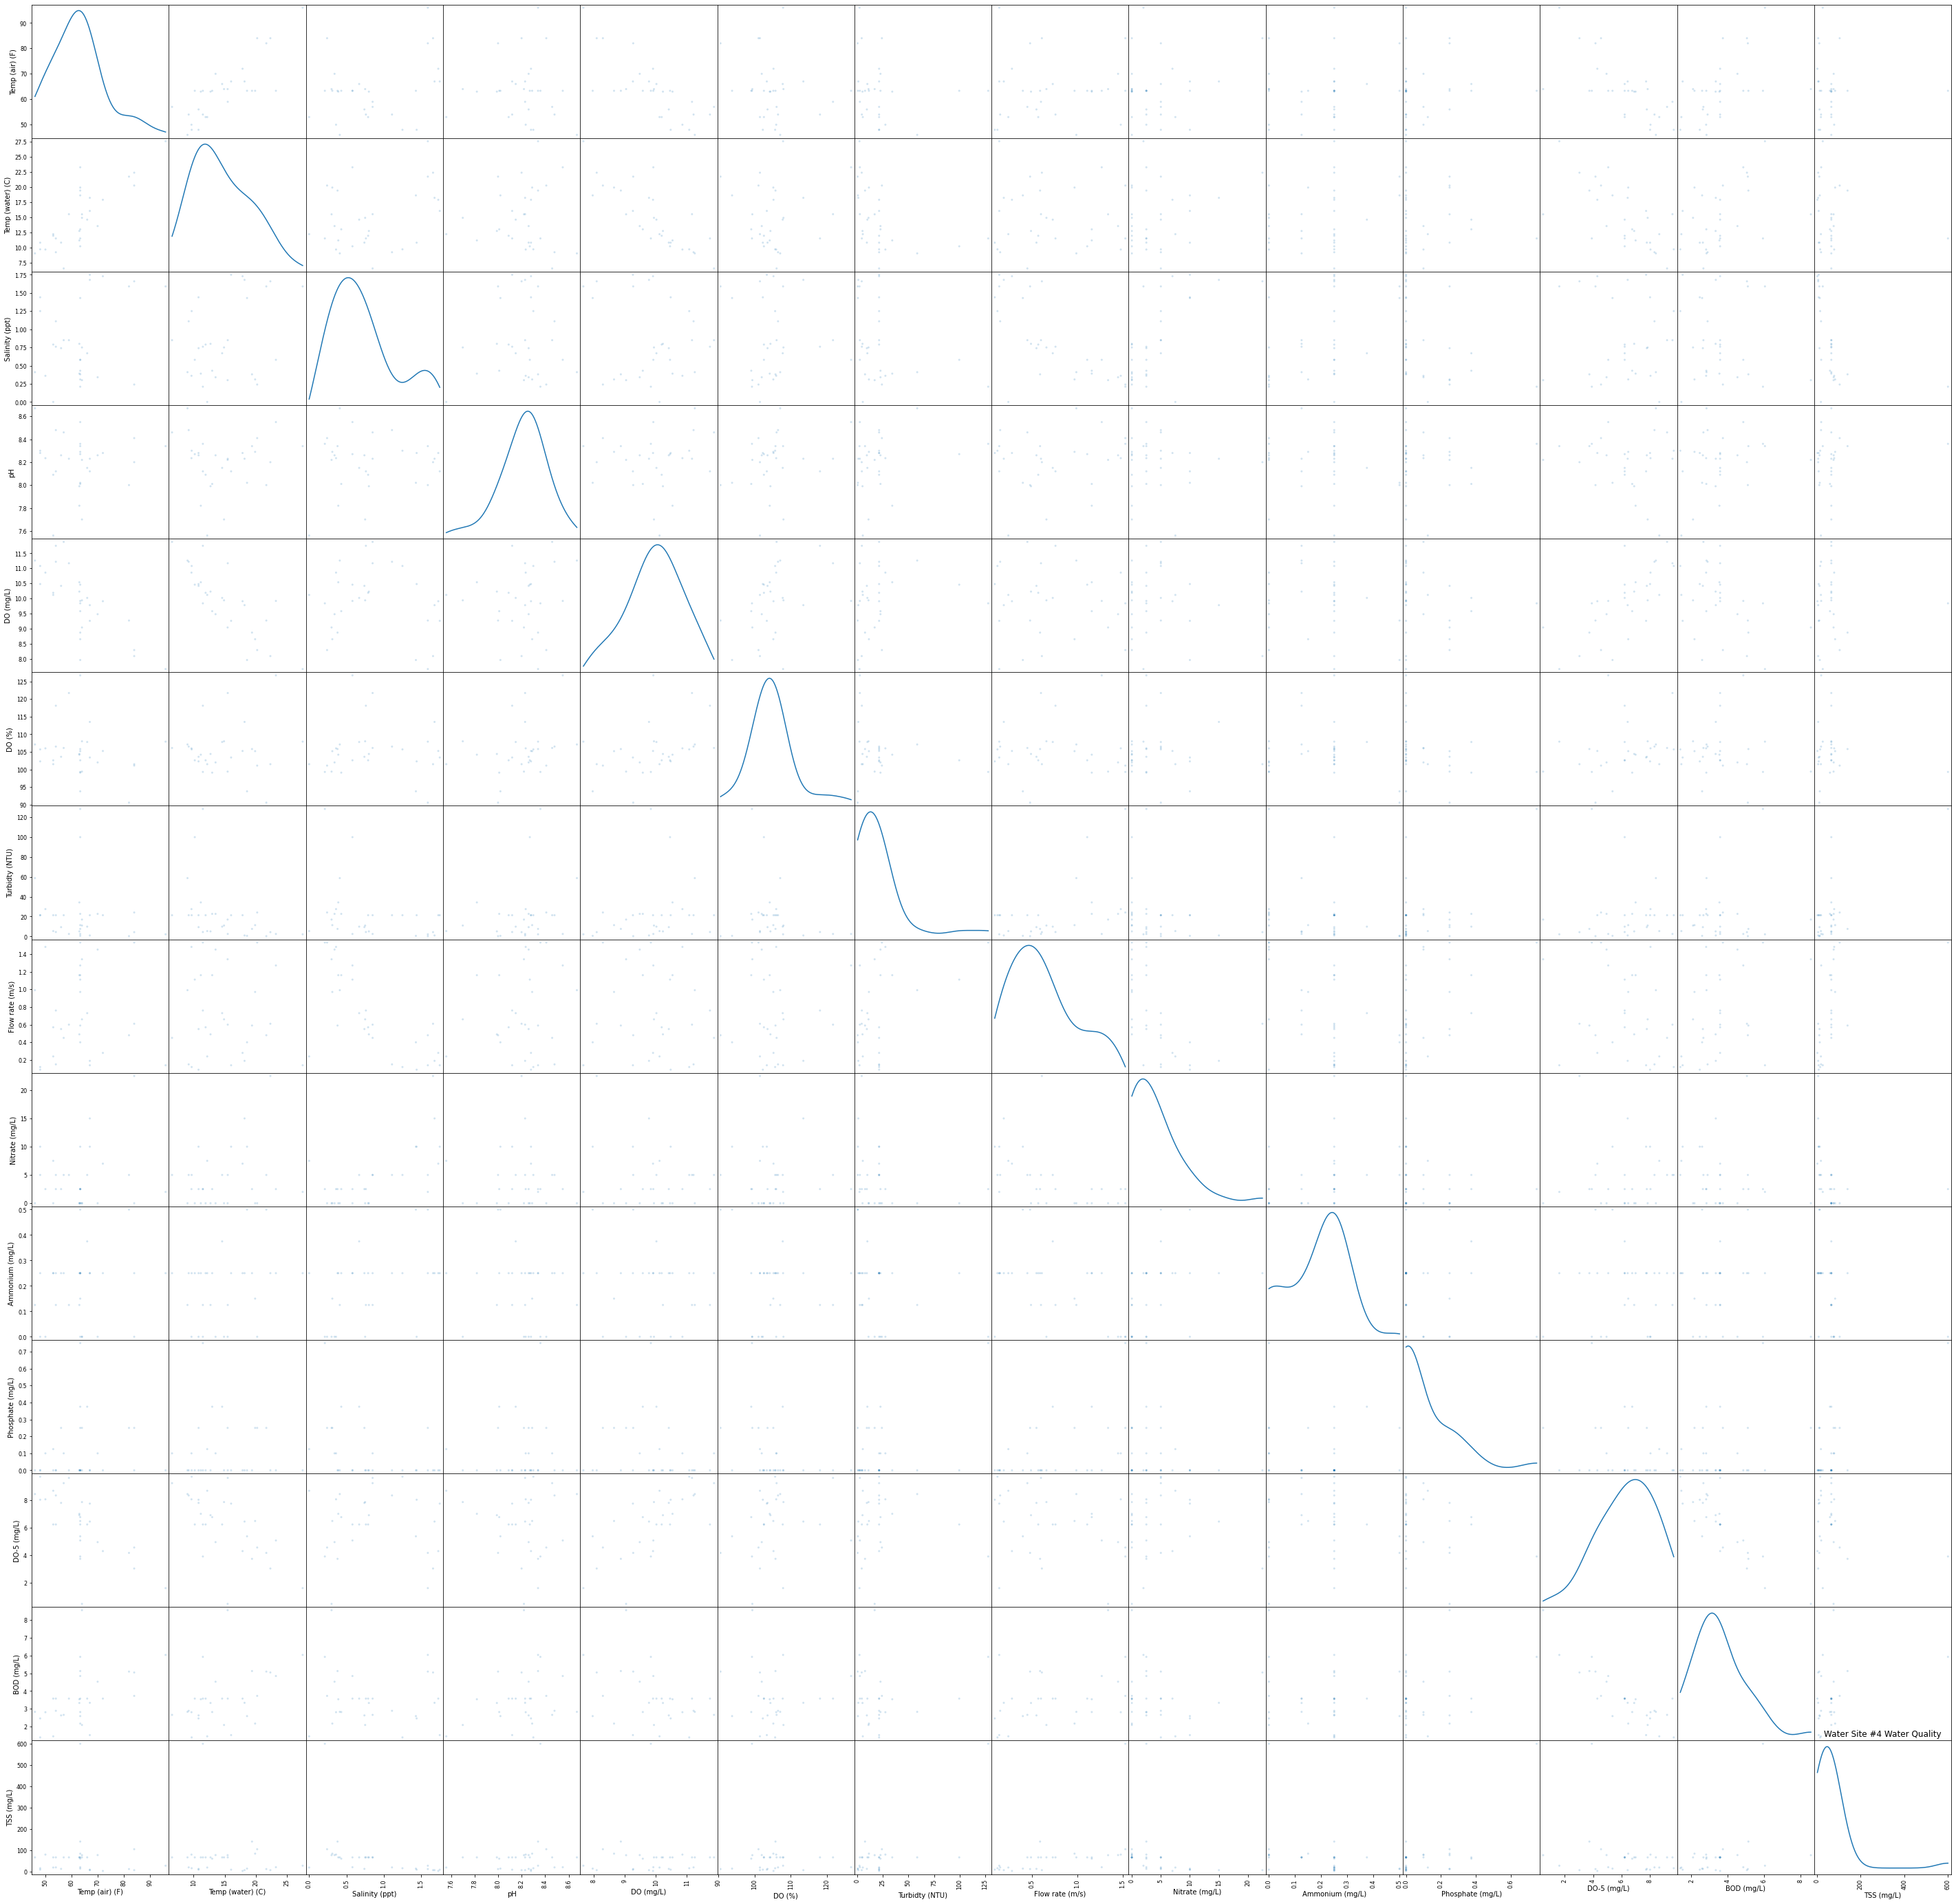

In [57]:
def make_scatter_matrix(dataframe, name, filename):
    figure = scatter_matrix(dataframe, alpha = 0.2, figsize = (50,50), diagonal = 'kde')
    plt.title(name)
    plt.savefig(filename)

make_scatter_matrix(water_quality_df_1, "Water Site #1 Water Quality",'water-site-1-sm.png')
make_scatter_matrix(water_quality_df_2, "Water Site #2 Water Quality",'water-site-2-sm.png')
make_scatter_matrix(water_quality_df_3, "Water Site #3 Water Quality",'water-site-3-sm.png')
make_scatter_matrix(water_quality_df_4, "Water Site #4 Water Quality",'water-site-4-sm.png')